
# Aggregate LRT JSON → Chi-square Comparison (REF vs DATA)

This notebook scans your output tree for `lrt_outputs.json` under both:
- `calibration/toy_*/lrt_outputs.json` (REF)
- `comparison/toy_*/lrt_outputs.json` (DATA)

It builds the two distributions from the `test` field and plots them.


In [6]:

import os, glob, json, math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import norm, chi2
import re
from pathlib import Path

# --- Style to match your example ---
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

# --- User config ---
BASE_DIR = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/LRT_with_unc/results/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_20_kernels_no_softmax"    # <- set this to the base folder containing calibration/ and comparison/
FIG_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(FIG_DIR, exist_ok=True)

# Defaults mirroring your example
NBINS   = 30
XMIN    = 0
XMAX    = 300
YMAX    = None
PRINT_Z = True

# If None, df is set to mean(REF); otherwise use a fixed number
DF_OVERRIDE = None

In [7]:
def _as_scalar_test(x):
    """Convert JSON 'test' to a float. If list or array, sum it."""
    if isinstance(x, (int, float)):
        return float(x)
    if isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            return float("nan")
        try:
            return float(np.nansum(np.asarray(x, dtype=float)))
        except Exception:
            return float("nan")
    return float("nan")


def _collect_mode_tests(base_dir, mode):
    """Return a 1D numpy array of toy-level test values for a mode."""
    patt = os.path.join(base_dir, mode, "toy_*", "lrt_outputs.json")
    tests = []
    for fp in sorted(glob.glob(patt)):
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            t = _as_scalar_test(obj.get("test"))
            if np.isfinite(t):
                tests.append(t)
        except Exception:
            pass
    return np.asarray(tests, dtype=float)


In [8]:
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.stats import norm


plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0.0

from scipy.stats import norm, chi2

# --- add near the top (once) if not already defined ---
DF_OVERRIDE = globals().get("DF_OVERRIDE", None)

def Z_score_chi2(t, df):
    """Asymptotic Z from chi2 survival function (and its p-value)."""
    sf = chi2.sf(t, df)      # 1 - CDF
    Z  = -norm.ppf(sf)       # one-sided Z
    return Z, sf             # return (Z, p-value)

def Z_score_chi2_from_empirical_median(t, ref_df_like=None):
    med = np.median(t)
    t_obs_err = 1.2533 * np.std(t) / np.sqrt(len(t))
    p_emp = 0.5
    Z  = norm.ppf(1 - p_emp)
    Zp = norm.ppf(1 - min(0.999999, max(1e-6, p_emp - 0.5 * t_obs_err / (np.std(t) + 1e-12))))
    Zm = norm.ppf(1 - min(0.999999, max(1e-6, p_emp + 0.5 * t_obs_err / (np.std(t) + 1e-12))))
    return Z, Zp - Z, Z - Zm

def fd_bins(x):
    """Numero di bin secondo Freedman–Diaconis."""
    x = np.asarray(x, float)
    if len(x) < 2:
        return 5
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    h = 2 * iqr / (len(x) ** (1/3) + 1e-12)
    if h <= 0:
        return 10
    nb = int(np.ceil((x.max() - x.min()) / h))
    return max(5, nb)

def _safe_xlim_from_data(t_all, xmin, xmax, pad_frac=0.05):
    """If provided x-lims don't cover the data, replace with padded data range."""
    t_all = np.asarray(t_all, float)
    dmin, dmax = np.min(t_all), np.max(t_all)
    if not np.isfinite(dmin) or not np.isfinite(dmax) or dmin == dmax:
        return xmin, xmax  # nothing to do
    # if user limits are None, or exclude the data range, recompute
    bad = (xmin is None or xmax is None or xmin >= xmax or dmax < xmin or dmin > xmax)
    if bad:
        span = dmax - dmin
        pad  = pad_frac * span if span > 0 else 1.0
        return dmin - pad, dmax + pad
    return xmin, xmax


def plot_2distribution_overlap_new(
    t1, t2, output_path, nbins=None, save=True,
    label1='REF (ensemble)', label2='DATA (ground truth)',
    save_name='probability_plot_ensemble_uq',
    print_Zscore=True, ymax=None, show_expectation=True,
    title='Ensemble with uncertainty modeling',
    xmin=None, xmax=None
):
    t1 = np.asarray(t1, float)
    t2 = np.asarray(t2, float)

    # --- figure: main axis + side panel ------------------------------------
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    ax  = fig.add_axes([0.10, 0.12, 0.62, 0.78])   # main plot (left)
    axp = fig.add_axes([0.76, 0.12, 0.20, 0.78])   # side panel (right)
    axp.axis('off')

    # --- bins ---------------------------------------------------------------
    t_all = np.concatenate([t1, t2]) if len(t2) else t1
    if nbins is None:
        nbins = fd_bins(t_all)
    bins = np.linspace(np.min(t_all), np.max(t_all), nbins + 1)
    binswidth = (np.max(t_all) - np.min(t_all)) / nbins
    xcenters = 0.5 * (bins[1:] + bins[:-1])
    # ---- degrees of freedom: use override or mean(REF) ---------------------
    df_local = DF_OVERRIDE if DF_OVERRIDE is not None else float(np.mean(t1))

    # ========================= REF (ensemble) ===============================
    Zr, p_r = Z_score_chi2(np.median(t1), df_local)
    med_err_r = 1.2533 * np.std(t1) / np.sqrt(len(t1))
    Zr_p, _   = Z_score_chi2(np.median(t1) + med_err_r, df_local)
    Zr_m, _   = Z_score_chi2(np.median(t1) - med_err_r, df_local)

    # --- legend text (only p-value and asymptotic Z) ------------------------
    label_ref_legend = f'{label1}\np-value: {p_r:.5f}\nasymptotic Z: {Zr:.2f} (+{Zr_p-Zr:.2f}/-{Zr-Zr_m:.2f})'

    h1 = ax.hist(
        t1,
        weights=np.ones_like(t1)/(t1.shape[0]*binswidth),
        color="#e186ed", alpha=0.5, bins=bins, label=label_ref_legend,
        edgecolor='none', linewidth=0
    )
    err1 = np.sqrt(h1[0] / (t1.shape[0] * binswidth))
    ax.errorbar(xcenters, h1[0], yerr=err1,
                color="#8a2be2", marker='o', ls='', alpha=0.6,
                markersize=5, capsize=2, elinewidth=0.8)

    # ========================== DATA (ground truth) =========================
    if len(t2):
        Zd, p_d = Z_score_chi2(np.median(t2), df_local)
        med_err_d = 1.2533 * np.std(t2) / np.sqrt(len(t2))
        Zd_p, _   = Z_score_chi2(np.median(t2) + med_err_d, df_local)
        Zd_m, _   = Z_score_chi2(np.median(t2) - med_err_d, df_local)

        # --- empirical Z (kept for side panel only) -------------------------
        t_emp = np.sum(t1 > np.mean(t2)) / len(t1)
        if t_emp == 0: 
            t_emp = 1.0/len(t1)
        t_emp_err = t_emp * np.sqrt(1.0 / (np.sum(t1 > np.mean(t2)) + 1.0/len(t1)))
        Z_emp   = norm.ppf(1 - t_emp)
        Z_emp_m = norm.ppf(1 - (t_emp + t_emp_err))
        Z_emp_p = norm.ppf(1 - (t_emp - t_emp_err))

        # legend: only p and asymptotic Z
        label_dat_legend = f'{label2}\np-value: {p_d:.5f}\nasymptotic Z: {Zd:.2f} (+{Zd_p-Zd:.2f}/-{Zd-Zd_m:.2f})'

        h2 = ax.hist(
            t2,
            weights=np.ones_like(t2)/(t2.shape[0]*binswidth),
            color="#68aedc", alpha=0.5, bins=bins, label=label_dat_legend,
            edgecolor='none', linewidth=0
        )
        err2 = np.sqrt(h2[0] / (t2.shape[0] * binswidth))
        ax.errorbar(xcenters, h2[0], yerr=err2,
                    color="#004c99", marker='o', ls='', alpha=0.6,
                    markersize=5, capsize=2, elinewidth=0.8)
    else:
        Z_emp = Z_emp_p = Z_emp_m = np.nan

    # ============================ side panel ================================
    axp.axis('off')
    panel_fp = font_manager.FontProperties(family='serif', size=20)
    from matplotlib.patches import Rectangle

    # --- 1) N_toys at the very top (alone) ---
    same_size = (len(t1) == len(t2)) if len(t2) else True
    N_toys = len(t1) if same_size else (len(t1), len(t2))
    axp.text(0.03, 0.98,
            rf'$N_{{\mathrm{{toys}}}} = {N_toys if isinstance(N_toys,int) else min(N_toys)}$',
            va='top', ha='left', fontproperties=panel_fp)

    # tighter, consistent spacing
    Y_REF_HDR  = 0.86
    Y_REF_TXT  = Y_REF_HDR - 0.045   # was -0.08
    Y_DATA_HDR = 0.66
    Y_DATA_TXT = Y_DATA_HDR - 0.045  # was -0.08

    # size + horizontal spacing for the swatch
    SW = 0.032   # side length in axis coords
    GAP = 0.012  # gap between swatch and text

    def _header(y, color_hex, text):
        """
        Draw a color swatch centered vertically on y, and a header label
        vertically centered on the same y. This guarantees alignment.
        """
        # center the square on (y): y - SW/2
        axp.add_patch(Rectangle((0.03, y - SW/2), SW, SW,
                                transform=axp.transAxes,
                                facecolor=color_hex, edgecolor='none', alpha=0.5))
        # center the text on y as well
        axp.text(0.03 + SW + GAP, y, text,
                va='center', ha='left', fontproperties=panel_fp, color='black')

    # --- REF block ---
    _header(Y_REF_HDR, "#e186ed", "REF (ensemble)")
    axp.text(0.03 + 0.036, Y_REF_TXT,
            rf'$\mathrm{{median}} = {np.median(t1):.2f}$, $\mathrm{{std}} = {np.std(t1):.2f}$',
            va='top', ha='left', fontproperties=panel_fp)

    # --- 3) DATA block (header + lines) ---
    _header(Y_DATA_HDR, "#68aedc", "DATA (ground truth)")

    # define safely for all code paths
    emp_line = ""
    if len(t2) and np.isfinite(Z_emp):
        emp_line = (rf'$\mathrm{{empirical}}\ Z = {Z_emp:.2f}\ '
                    rf'(+{Z_emp_p-Z_emp:.2f}/-{Z_emp-Z_emp_m:.2f})$')

    axp.text(0.03 + 0.036, Y_DATA_TXT,
            rf'$\mathrm{{median}} = {np.median(t2):.2f}$, '
            rf'$\mathrm{{std}} = {np.std(t2):.2f}$' +
            (("\n" + emp_line) if emp_line else ""),
            va='top', ha='left', fontproperties=panel_fp)

    # ============================ styling ==================================
    legend_fp = font_manager.FontProperties(family='serif', size=16.5)
    ax.legend(ncol=1, loc='upper right', prop=legend_fp, frameon=False,
            handlelength=1.8, borderpad=0.3, labelspacing=0.3)

    ax.set_xlabel(r'$t$', fontsize=32, fontname="serif")
    ax.set_ylabel('Probability', fontsize=32, fontname="serif")


    # and add one math-text multiplier under the axis
    ax.set_xlabel(r'$t$', fontsize=32, fontname="serif")


    if ymax is not None:
        ax.set_ylim(0., ymax)
    xmin, xmax = _safe_xlim_from_data(t_all, xmin, xmax)
    if (xmin is not None) or (xmax is not None):
        ax.set_xlim(xmin if xmin is not None else ax.get_xlim()[0],
                    xmax if xmax is not None else ax.get_xlim()[1])

    ax.set_yticks(ax.get_yticks())  # just to trigger font below
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)

    if title:
        ax.set_title(title, fontsize=30, fontname="serif", pad=14)

    plt.tight_layout()
    if save:
        fn = os.path.join(output_path, save_name + '.pdf')
        fig.savefig(fn, bbox_inches="tight", pad_inches=0.01)
        print("Saved figure to:", fn)
    plt.show()
    plt.close()


In [9]:
# --- thin wrapper, now forwards labels + N_ref/N_data + title/save_name ---
def plot_2distribution_like_example(
    t_ref, t_data, df_val,
    output_path, xmin=None, xmax=None, ymax=None, nbins=None,
    save=True,
    label1='REF (ensemble)', label2='DATA (ground truth)',
    save_name='probability_plot_ensemble_uq',
    print_Zscore=True,
    title='Ensemble with uncertainty modeling'
):
    """
    Wrapper that sets DF_OVERRIDE=df_val and forwards to plot_2distribution_overlap_new
    while honoring axes, bins, labels, title, save_name, and N_ref/N_data.
    """
    global DF_OVERRIDE
    prev_df = DF_OVERRIDE
    DF_OVERRIDE = df_val
    try:
        os.makedirs(output_path, exist_ok=True)
        return plot_2distribution_overlap_new(
            t_ref, t_data,
            output_path=output_path,
            nbins=nbins,
            save=save,
            label1=label1, label2=label2,
            save_name=save_name,
            print_Zscore=print_Zscore,
            ymax=ymax,
            show_expectation=True,
            title=title,
            xmin=xmin, xmax=xmax)
    finally:
        DF_OVERRIDE = prev_df


/tmp/ipykernel_96309/3013552538.py:221: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to: /work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/LRT_with_unc/results/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_20_kernels_no_softmax/plots/probability_plot_ensemble_uq.pdf


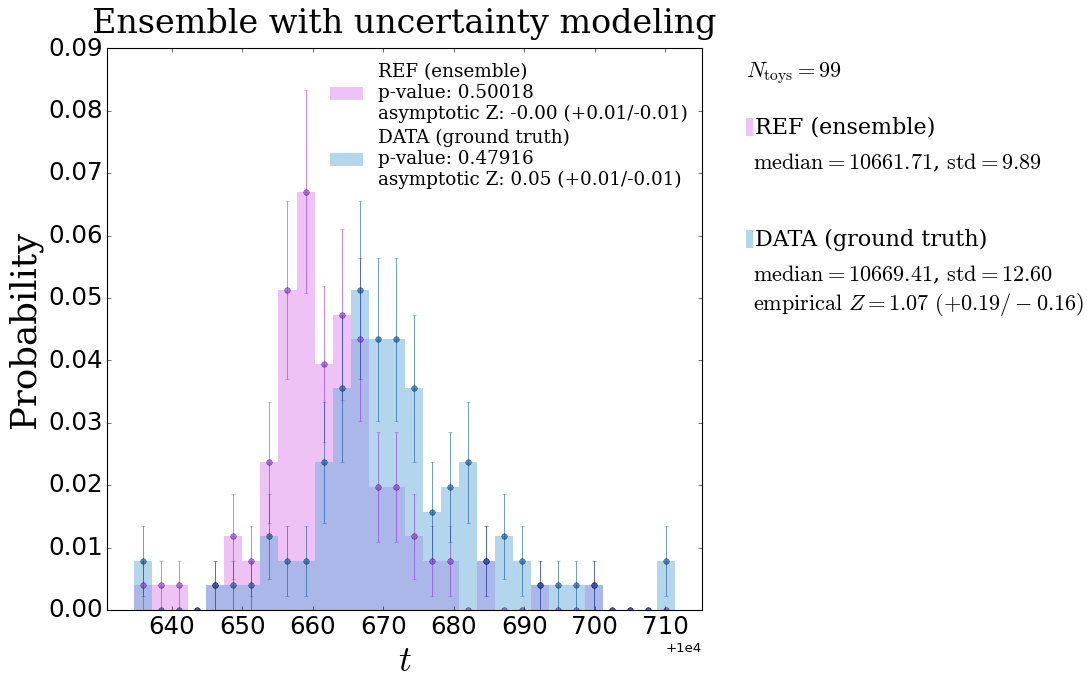

In [10]:
if __name__ == "__main__":
    t_ref = _collect_mode_tests(BASE_DIR, "calibration")
    t_data = _collect_mode_tests(BASE_DIR, "comparison")

    # chi^2 dof
    df_val = float(np.mean(t_ref)) if DF_OVERRIDE is None else int(float(DF_OVERRIDE))

    os.makedirs(FIG_DIR, exist_ok=True)

    # declare the totals you want shown in the side panel

    plot_2distribution_like_example(
        t_ref, t_data, df_val,
        output_path=FIG_DIR,
        xmin=XMIN, xmax=XMAX, ymax=YMAX, nbins=NBINS,
        save=True,
        label1='REF (ensemble)',
        label2='DATA (ground truth)',
        save_name='probability_plot_ensemble_uq',
        print_Zscore=PRINT_Z,
        title='Ensemble with uncertainty modeling')


In [42]:
import glob, os

calib_files = sorted(glob.glob(os.path.join(BASE_DIR, "calibration", "toy_*", "lrt_outputs.json")))
print("Found calibration JSON files:", len(calib_files))

Found calibration JSON files: 100


In [54]:
bad_files = []
tests = []
for fp in calib_files:
    with open(fp, "r") as f:
        obj = json.load(f)
    t = obj.get("test")
    try:
        val = float(np.nansum(np.asarray(t, dtype=float))) if not isinstance(t, (int,float)) else float(t)
    except Exception:
        val = float("nan")
    if not np.isfinite(val):
        bad_files.append(fp)
    else:
        tests.append(val)

print("Total good values:", len(tests))
print("Bad/missing values:", len(bad_files))
for bf in bad_files:
    print("Bad file:", bf)

Total good values: 99
Bad/missing values: 1
Bad file: /work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/LRT_with_unc/results/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_20_kernels_no_softmax/calibration/toy_82/lrt_outputs.json


In [ ]:
t_ref = np.asarray(tests, float)
print("Final REF length:", len(t_ref))

Final REF length: 99


In [ ]:
import re, json, numpy as np, os, glob

calib_files = sorted(glob.glob(os.path.join(BASE_DIR, "calibration", "toy_*", "lrt_outputs.json")))
bad_files = []

def to_float_or_nan(t):
    if isinstance(t, (int, float)):
        return float(t)
    if isinstance(t, (list, tuple, np.ndarray)):
        if len(t) == 0:
            return float("nan")    # empty payload
        try:
            return float(np.nansum(np.asarray(t, dtype=float)))
        except Exception:
            return float("nan")
    return float("nan")

for fp in calib_files:
    with open(fp, "r") as f:
        obj = json.load(f)
    val = to_float_or_nan(obj.get("test"))
    if not np.isfinite(val):
        bad_files.append((fp, obj))

print("Bad count:", len(bad_files))
for fp, obj in bad_files:
    m = re.search(r"(toy_\d+)", fp)
    toy_id = m.group(1) if m else "toy_???"
    print("\nBAD:", fp)
    print("Toy id:", toy_id)
    print("JSON keys:", list(obj.keys()))
    print("test raw value:", obj.get("test"))

Bad count: 1

BAD: /work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/LRT_with_unc/results/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_20_kernels_no_softmax/calibration/toy_82/lrt_outputs.json
Toy id: toy_82
JSON keys: ['num', 'den', 'test']
test raw value: nan
